In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\Yoyo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class QLearning:
    
    def __init__(self, n_actions, n_states, gamma=0.9, epsilon=0.9, lr=0.001):
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        
        tf.reset_default_graph()
        self.sess = tf.Session()
        
        self.state_input = tf.placeholder(tf.float32, shape=[None, self.n_states], name='input')
        self.target = tf.placeholder(tf.float32, shape=[None, self.n_actions], name='target')
        
        with tf.variable_scope('Q_table'):
            self.q_eval = self.build_network('net_eval')
            
        self.Qnet_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Q_table/net_eval')
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.q_eval, self.target))        
        self.train = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, var_list=self.Qnet_params)
        
        self.sess.run(tf.global_variables_initializer())
        
    def build_network(self, scope):
        with tf.variable_scope(scope):
            h1 = tf.layers.dense(inputs=self.state_input, units=5, activation=tf.nn.tanh)
            h2 = tf.layers.dense(inputs=h1, units=5, activation=tf.nn.tanh)
        return tf.layers.dense(inputs=h2, units=self.n_actions)
    
    def choose_action(self, current_state):
        if np.random.uniform() < self.epsilon:
            q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: 
                                                           current_state[np.newaxis, :]})
            self.action = np.argmax(q_eval)
        else:
            self.action = np.random.randint(0, self.n_actions)
        return self.action
        
    def learn(self, current_state, reward, next_state):
        q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input:
                                                      current_state[np.newaxis, :]})
        q_eval_next = self.sess.run(self.q_eval, feed_dict={self.state_input:
                                                           next_state[np.newaxis, :]})
        q_target = q_eval.copy()
        q_target[:, self.action] = reward + self.gamma * q_eval_next.max()
        _, self.cost = self.sess.run([self.train, self.loss], feed_dict={self.state_input: 
                                                          next_state[np.newaxis, :],
                                                         self.target:
                                                         q_target})
        
    def model_save(self, model_name):
        saver = tf.train.Saver()
        saver.save(self.sess, 'saved_models/{}.ckpt'.format(model_name))
    
    def mode_restore(self, model_name):
        saver = tf.train.Saver()
        saver.restore(self.sess, 'saved_model/{}.ckpt'.format(model_name))


In [3]:
def training(save_model, model_name):
    reward_record = []
    for episode in range(50):
        total_reward = 0
        current_state = env.reset()
        
        while True:
            env.render()
            
            action = RL.choose_action(current_state)
            
            next_state, reward, done = env.step(action)
            
            total_reward += reward
            
            RL.learn(current_state, reward, next_state)
            
            current_state = next_state
            
            if done:
                print('Total Reward: {}'.format(total_reward))
                reward_record.append(total_reward)
                break
                
    if save_model:
        RL.model_save(model_name)
    print('Game Over!')
    env.close
    return reward_record

In [4]:
import os
os.sys.path.append('environment/')
import Mario2

env = Mario2.make()
reward_result = []
for i in range(5):
    RL = QLearning(n_actions = env.n_actions,
                  n_states = env.n_features,
                  gamma = (i*2 + 1)/10,
                  epsilon = 0.9,
                  lr = 0.01
                  )
    print('episode{} start: gamma={}'.format(i, (i*2+1)/10))
    reward_record = training(save_model = True, model_name='gamma_p{}'.format(i*2+1))
    reward_result.append(pd.DataFrame(data = reward_record))

episode0 start: gamma=0.1
Total Reward: -17.499999999999996
Total Reward: -7.2999999999999865
Total Reward: -9.799999999999981
Total Reward: -13.899999999999967
Total Reward: -4.599999999999996
Total Reward: -6.599999999999989
Total Reward: -0.7000000000000004
Total Reward: -25.900000000000084
Total Reward: 0.5
Total Reward: 0.4
Total Reward: 0.10000000000000009
Total Reward: -4.299999999999997
Total Reward: -2.800000000000002
Total Reward: -10.299999999999976
Total Reward: -7.499999999999986
Total Reward: -46.10000000000034
Total Reward: -3.3000000000000007
Total Reward: -7.699999999999985
Total Reward: -4.899999999999995
Total Reward: -38.200000000000216
Total Reward: -30.70000000000018
Total Reward: -8.099999999999987
Total Reward: -31.200000000000166
Total Reward: -9.599999999999978
Total Reward: -47.6000000000004
Total Reward: -12.79999999999997
Total Reward: -21.60000000000004
Total Reward: -30.000000000000178
Total Reward: -1.2000000000000006
Total Reward: -3.000000000000001
Tot

Total Reward: -840.5000000001197
Total Reward: -4908.300000000288
Total Reward: -10.099999999999987
Total Reward: -422.00000000002717
Total Reward: -1942.5999999993444
Total Reward: -164.19999999999501
Total Reward: -394.50000000002
Game Over!


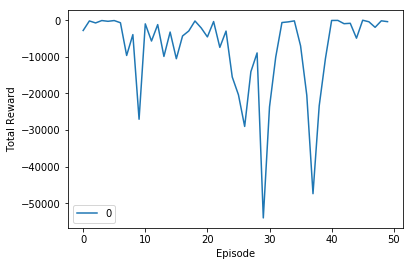

In [5]:
reward_result = pd.DataFrame(reward_record)
reward_result.plot()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()